In [29]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
import matplotlib


We are going to do time series analysis and forecasting for furniture sales.

In [30]:
df = pd.read_excel("Superstore.xls")
furniture = df.loc[df['Category'] == 'Furniture']

We have a good 4-year furniture sales data. 

In [31]:
furniture['Order Date'].min()

Timestamp('2014-01-06 00:00:00')

In [32]:
furniture['Order Date'].max()

Timestamp('2017-12-30 00:00:00')

## Data preprocessing

This step includes removing columns we do not need, check missing values, aggregate sales by date and so on.

In [33]:
cols = ['Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')

In [34]:
furniture.isnull().sum()

Order Date    0
Sales         0
dtype: int64

In [35]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()

In [36]:
furniture.head()

,Order Date,Sales
0,2014-01-06,2573.820
1,2014-01-07,76.728
2,2014-01-10,51.940
3,2014-01-11,9.940
4,2014-01-13,879.939


## Indexing with time series data

In [37]:
furniture = furniture.set_index('Order Date')
furniture.index

DatetimeIndex(['2014-01-06', '2014-01-07', '2014-01-10', '2014-01-11',
               '2014-01-13', '2014-01-14', '2014-01-16', '2014-01-19',
               '2014-01-20', '2014-01-21',
               ...
               '2017-12-18', '2017-12-19', '2017-12-21', '2017-12-22',
               '2017-12-23', '2017-12-24', '2017-12-25', '2017-12-28',
               '2017-12-29', '2017-12-30'],
              dtype='datetime64[ns]', name='Order Date', length=889, freq=None)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.

In [38]:
y = furniture['Sales'].resample('MS').mean()

Have a quick peek 2017 sales data.

In [39]:
y['2017':]

Order Date
2017-01-01     397.602133
2017-02-01     528.179800
2017-03-01     544.672240
2017-04-01     453.297905
2017-05-01     678.302328
2017-06-01     826.460291
2017-07-01     562.524857
2017-08-01     857.881889
2017-09-01    1209.508583
2017-10-01     875.362728
2017-11-01    1277.817759
2017-12-01    1256.298672
Freq: MS, Name: Sales, dtype: float64

## Visualizing furniture sales time series data

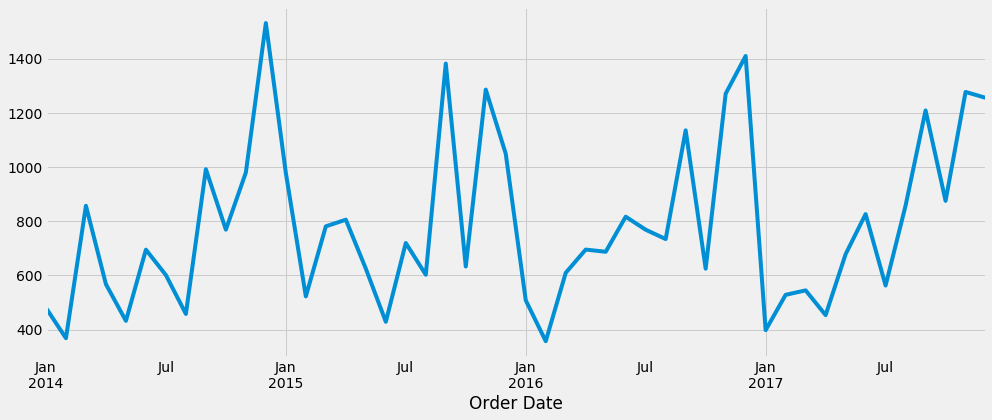

In [40]:
y.plot(figsize=(15, 6))
plt.show()

Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern, such as sales are always low at the beginning of the year and high at the end of the year. There is always a strong upward trend within any single year with a couple of low months in the mid of the year.

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

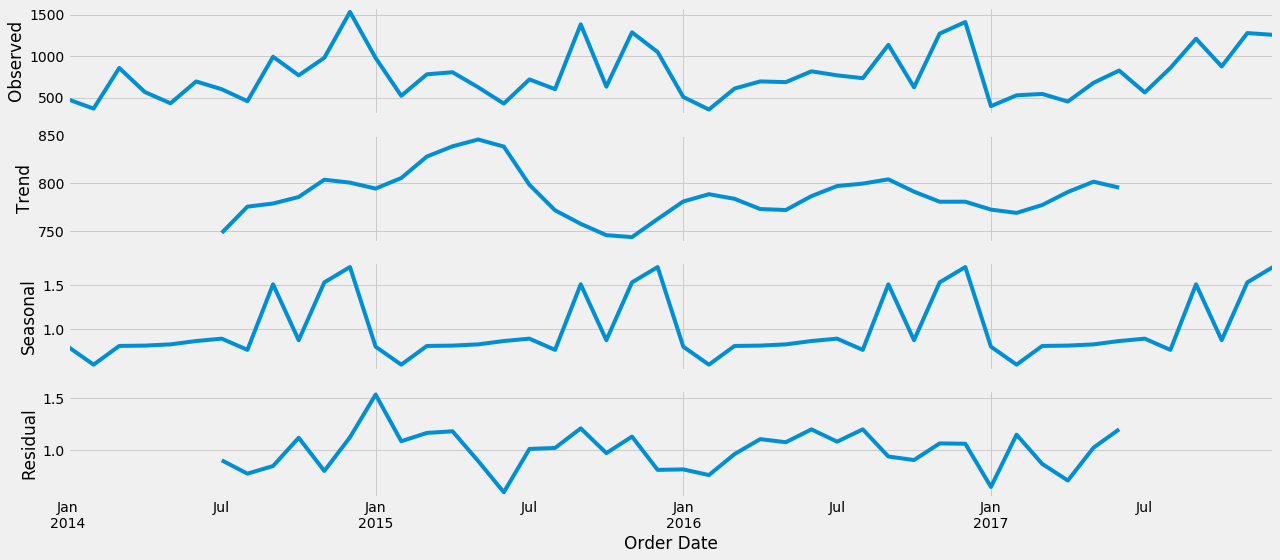

In [41]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
fig = decomposition.plot()
plt.show()


The plot above clearly shows that the sales of furniture is unstable, along with its obvious seasonality.

## Time series forecasting with ARIMA

We are going to apply one of the most commonly used method for time-series forecasting, known as ARIMA, which stands for Autoregressive Integrated Moving Average.

Parameter Selection for the ARIMA Time Series Model

In [42]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [43]:
AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}24 - AIC:{}'.format(param, param_seasonal, results.aic))
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)24 - AIC:769.0817523205916
ARIMA(0, 0, 0)x(0, 0, 1, 12)24 - AIC:1446.5593227130305
ARIMA(0, 0, 0)x(0, 1, 0, 12)24 - AIC:477.7170130920218
ARIMA(0, 0, 0)x(1, 0, 0, 12)24 - AIC:497.23144334183365
ARIMA(0, 0, 0)x(1, 0, 1, 12)24 - AIC:1172.208674145885
ARIMA(0, 0, 0)x(1, 1, 0, 12)24 - AIC:318.0047199116341
ARIMA(0, 0, 1)x(0, 0, 0, 12)24 - AIC:720.9252270758095
ARIMA(0, 0, 1)x(0, 0, 1, 12)24 - AIC:2900.357535652858
ARIMA(0, 0, 1)x(0, 1, 0, 12)24 - AIC:466.56074298091255
ARIMA(0, 0, 1)x(1, 0, 0, 12)24 - AIC:499.574045803366
ARIMA(0, 0, 1)x(1, 0, 1, 12)24 - AIC:2513.1394870316744
ARIMA(0, 0, 1)x(1, 1, 0, 12)24 - AIC:319.98848769468657
ARIMA(0, 1, 0)x(0, 0, 0, 12)24 - AIC:677.894766843944
ARIMA(0, 1, 0)x(0, 0, 1, 12)24 - AIC:1250.2320272227237
ARIMA(0, 1, 0)x(0, 1, 0, 12)24 - AIC:486.63785672282035
ARIMA(0, 1, 0)x(1, 0, 0, 12)24 - AIC:497.78896630044073
ARIMA(0, 1, 0)x(1, 0, 1, 12)24 - AIC:1550.2003231687213
ARIMA(0, 1, 0)x(1, 1, 0, 12)24 - AIC:319.7714068109211
ARI

In [44]:
print('The smallest AIC is {} for model SARIMAX{}x{}'.format(min(AIC), SARIMAX_model[AIC.index(min(AIC))][0],SARIMAX_model[AIC.index(min(AIC))][1]))

The smallest AIC is 297.7875439553055 for model SARIMAX(1, 1, 1)x(1, 1, 0, 12)


In [45]:
SARIMAX_model[AIC.index(min(AIC))][0]

(1, 1, 1)

In [46]:
SARIMAX_model[AIC.index(min(AIC))][1]

(1, 1, 0, 12)

In [47]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=SARIMAX_model[AIC.index(min(AIC))][0],
                                seasonal_order=SARIMAX_model[AIC.index(min(AIC))][1],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0146      0.342      0.043      0.966      -0.655       0.684
ma.L1         -1.0000      0.360     -2.781      0.005      -1.705      -0.295
ar.S.L12      -0.0253      0.042     -0.609      0.543      -0.107       0.056
sigma2      2.958e+04   1.22e-05   2.43e+09      0.000    2.96e+04    2.96e+04


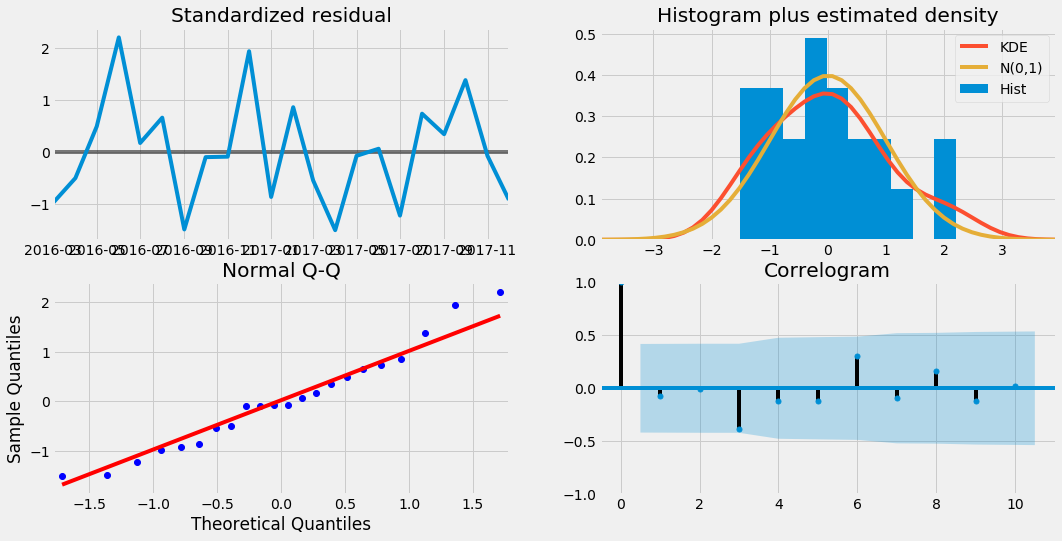

In [48]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Validating forecasts

To help us understand the accuracy of our forecasts, we compare predicted sales to real sales of the time series, and we set forecasts to start at 2017-07-01 to the end of the data.

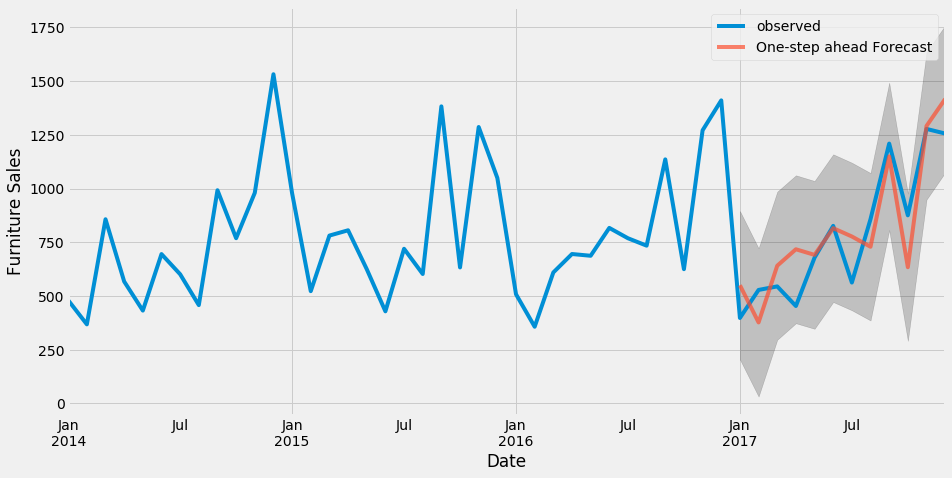

In [49]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.legend()

plt.show()

The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the year.

In [50]:
y_forecasted = pred.predicted_mean
y_truth = y['2017-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 22993.58


In [51]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 151.64


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average daily furniture sales in the test set within 151.64 of the real sales. Our furniture daily sales range from around 400 to over 1200. In my opinion, this is a pretty good model so far.

## Producing and visualizing forecasts

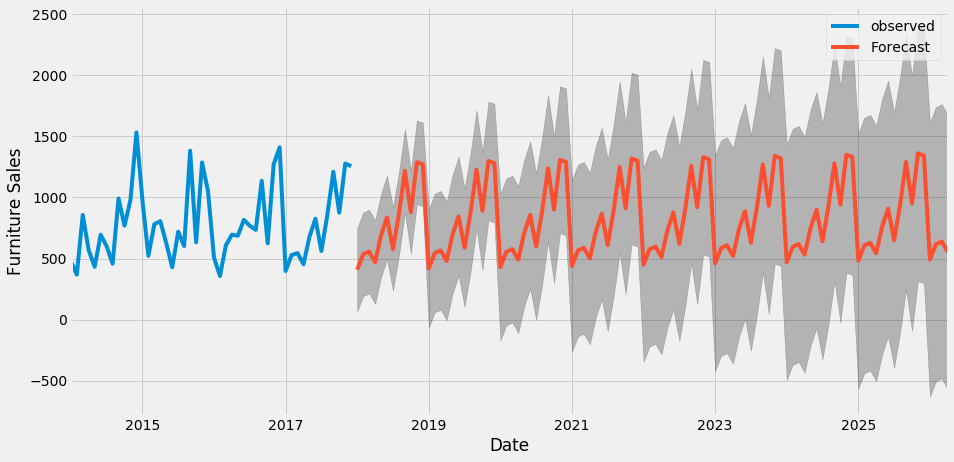

In [52]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int()

ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')

plt.legend()
plt.show()